In [1]:
# импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
# задаем нормализующие преобразования, загружаем набор MNIST и разбиваем данные на подвыборки
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 78744263.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92329034.93it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23596879.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9835069.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Test data: 10000


In [3]:
# используем GPU если возможно
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [4]:
# создаем класс НС на основе torch
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [5]:
# проверяем работоспособность созданного класса
model = Net().to(device)

In [6]:
# создаем оптимизатор, функцию потреть и трейнер сети
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [7]:
# определяем функцию обучения сети
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [8]:
# обучаем модель
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2929983610663845 Val_Loss: 0.14282329050162185
Epoch: 2 Loss: 0.11167306516834545 Val_Loss: 0.10023150670196206
Epoch: 3 Loss: 0.08669009416963834 Val_Loss: 0.08876393548660906
Epoch: 4 Loss: 0.07547891725945295 Val_Loss: 0.08737611839261517
Epoch: 5 Loss: 0.06766004898735753 Val_Loss: 0.09118692035006895
Epoch: 6 Loss: 0.062466110574673946 Val_Loss: 0.08722920042319367
Epoch: 7 Loss: 0.06020658712990241 Val_Loss: 0.09637939314217543
Epoch: 8 Loss: 0.05766215919957994 Val_Loss: 0.08769152700292669
Epoch: 9 Loss: 0.05625135024997346 Val_Loss: 0.07799628196370527
Epoch: 10 Loss: 0.056682715699112735 Val_Loss: 0.1033533448469157


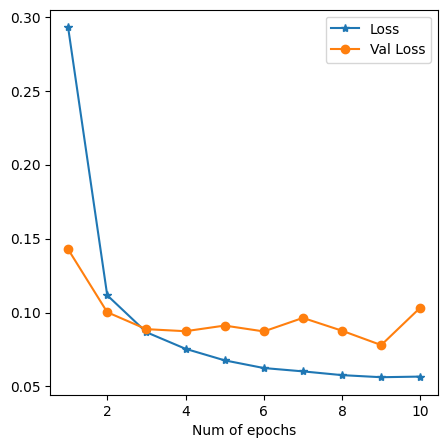

In [9]:
# строим график
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [10]:
# создаем функции атак
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [11]:
# создаем функци. проверки
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

Epsilon: 0	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.007	Test Accuracy = 9675 / 10000 = 0.9675
Epsilon: 0.01	Test Accuracy = 9654 / 10000 = 0.9654
Epsilon: 0.02	Test Accuracy = 9617 / 10000 = 0.9617
Epsilon: 0.03	Test Accuracy = 9548 / 10000 = 0.9548
Epsilon: 0.05	Test Accuracy = 9364 / 10000 = 0.9364
Epsilon: 0.1	Test Accuracy = 8487 / 10000 = 0.8487
Epsilon: 0.2	Test Accuracy = 5409 / 10000 = 0.5409
Epsilon: 0.3	Test Accuracy = 2789 / 10000 = 0.2789


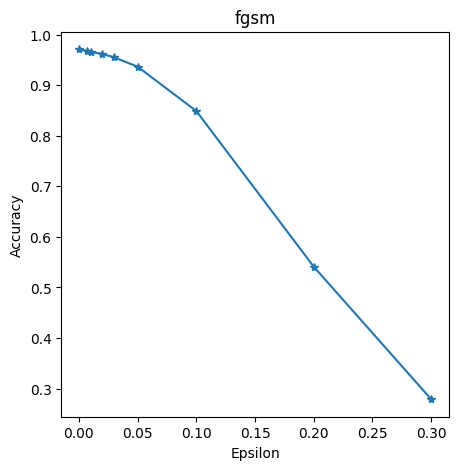

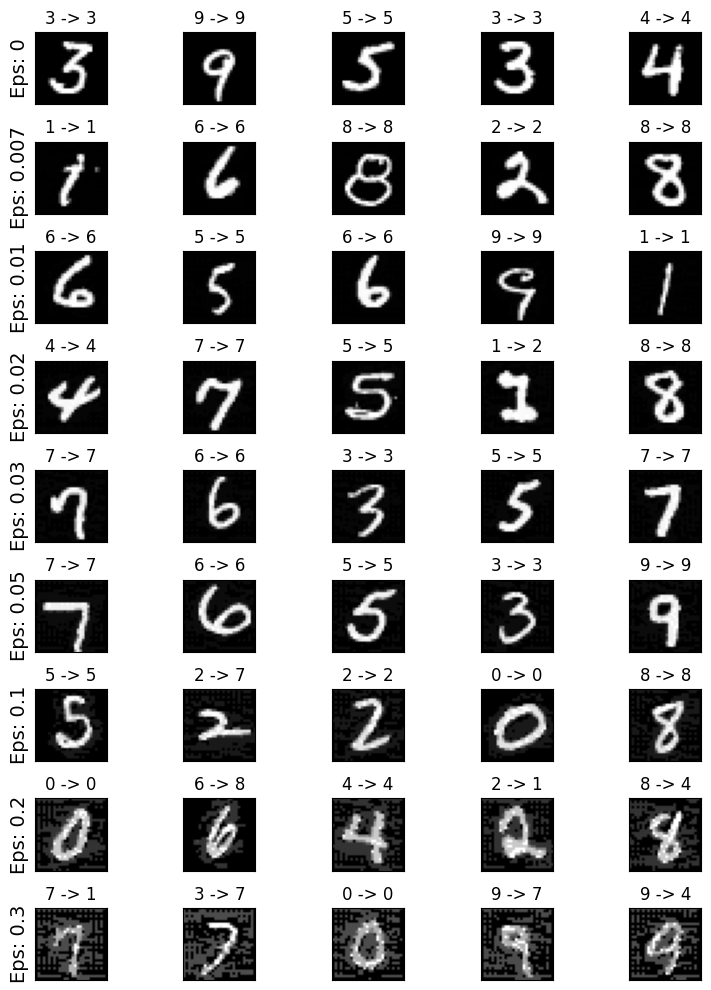

Epsilon: 0	Test Accuracy = 9708 / 10000 = 0.9708
Epsilon: 0.007	Test Accuracy = 9677 / 10000 = 0.9677
Epsilon: 0.01	Test Accuracy = 9666 / 10000 = 0.9666
Epsilon: 0.02	Test Accuracy = 9622 / 10000 = 0.9622
Epsilon: 0.03	Test Accuracy = 9563 / 10000 = 0.9563
Epsilon: 0.05	Test Accuracy = 9387 / 10000 = 0.9387
Epsilon: 0.1	Test Accuracy = 8463 / 10000 = 0.8463
Epsilon: 0.2	Test Accuracy = 5445 / 10000 = 0.5445
Epsilon: 0.3	Test Accuracy = 2837 / 10000 = 0.2837


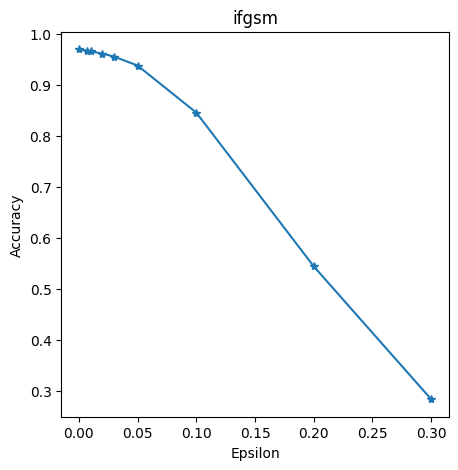

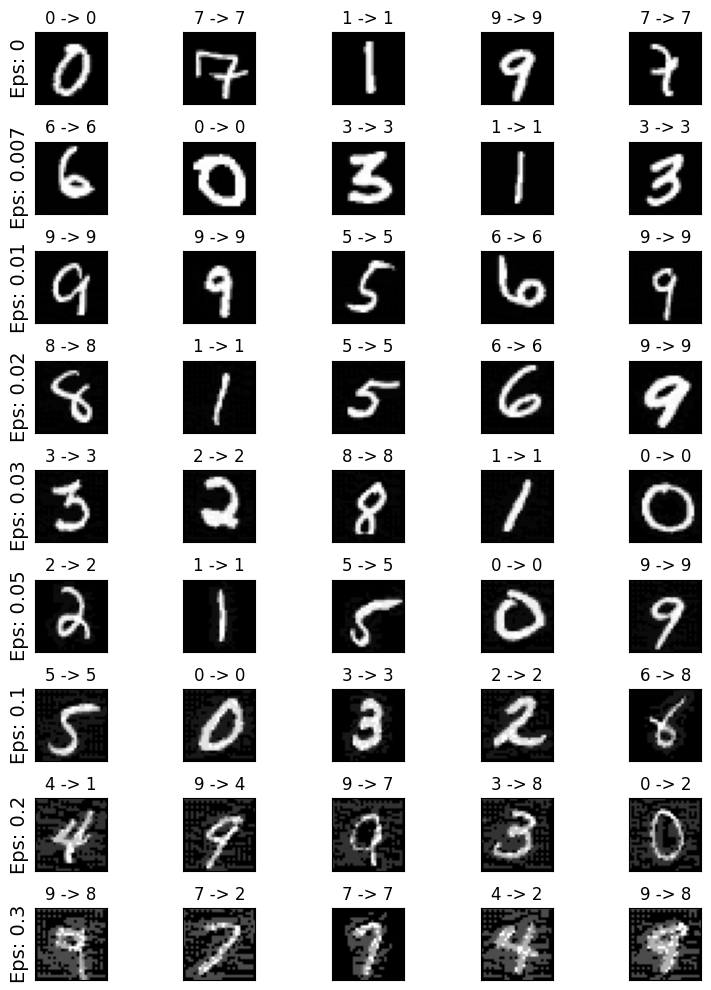

Epsilon: 0	Test Accuracy = 9700 / 10000 = 0.97
Epsilon: 0.007	Test Accuracy = 9696 / 10000 = 0.9696
Epsilon: 0.01	Test Accuracy = 9676 / 10000 = 0.9676
Epsilon: 0.02	Test Accuracy = 9621 / 10000 = 0.9621
Epsilon: 0.03	Test Accuracy = 9579 / 10000 = 0.9579
Epsilon: 0.05	Test Accuracy = 9432 / 10000 = 0.9432
Epsilon: 0.1	Test Accuracy = 8723 / 10000 = 0.8723
Epsilon: 0.2	Test Accuracy = 6155 / 10000 = 0.6155
Epsilon: 0.3	Test Accuracy = 3324 / 10000 = 0.3324


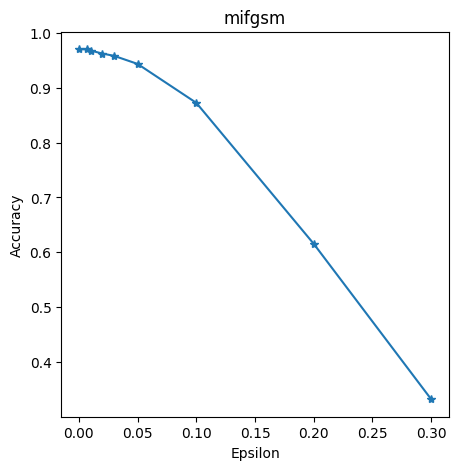

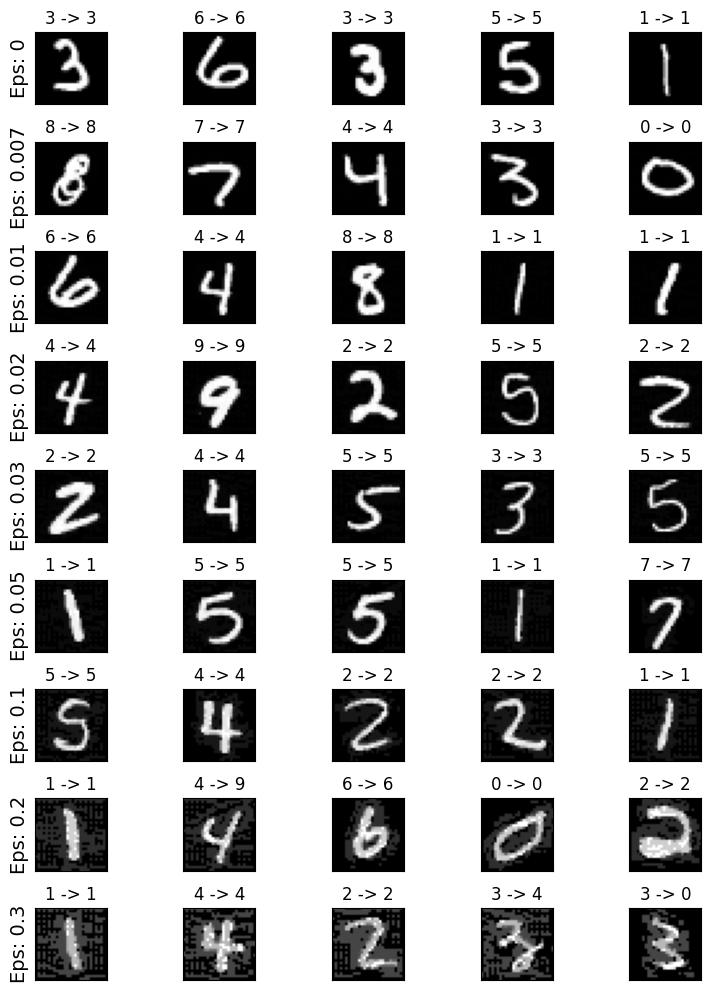

In [12]:
# строим графики успешности атак и примеры выполненых атак в зависимости от степени возмущения epsilon
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

In [13]:
# создаем два класса НС
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [14]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

In [15]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5448293192800642 Val_Loss: 7.73291103541851e-06
Epoch: 2 Loss: 0.2927316698674613 Val_Loss: 1.0102411732077599e-06
Epoch: 3 Loss: 0.2102989830346451 Val_Loss: 6.601312197744847e-07
Epoch: 4 Loss: 0.16505023587049214 Val_Loss: 7.533462459105067e-06
Epoch: 5 Loss: 0.13952160401099645 Val_Loss: 4.4946352019906044e-06
Epoch: 6 Loss: 0.12023352776694962 Val_Loss: 1.9566755509003998e-07
Epoch: 7 Loss: 0.11333786990761777 Val_Loss: 1.9792682214756497e-06
Epoch: 8 Loss: 0.1019939355488022 Val_Loss: 4.203413613140583e-07
Epoch: 9 Loss: 0.0976399402378025 Val_Loss: 2.3648618487641217e-06
Epoch: 10 Loss: 0.09295012344814668 Val_Loss: 7.459939115506131e-08


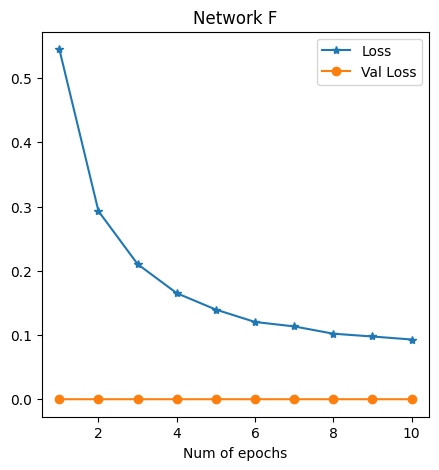

Fitting the model...
Epoch: 1 Loss: 0.6363280130847226 Val_Loss: 4.991228529252112e-06
Epoch: 2 Loss: 0.42811888280111854 Val_Loss: 6.821165650617332e-05
Epoch: 3 Loss: 0.3726626193641786 Val_Loss: 0.0001593279018998146
Epoch: 4 Loss: 0.3215511648770174 Val_Loss: 9.6123790089041e-05
Epoch: 5 Loss: 0.2729614160263343 Val_Loss: 1.9890321791172028e-05
Epoch: 6 Loss: 0.2336730380693122 Val_Loss: 1.418686844408512e-05
Epoch: 7 Loss: 0.22432161142330115 Val_Loss: 5.9460494473751167e-05
Epoch: 8 Loss: 0.22250396553932653 Val_Loss: 2.616085112094879e-07
Epoch: 9 Loss: 0.21347470993006776 Val_Loss: 2.3429323930758982e-05
Epoch: 10 Loss: 0.21204543162817313 Val_Loss: 1.9299010455142708e-08


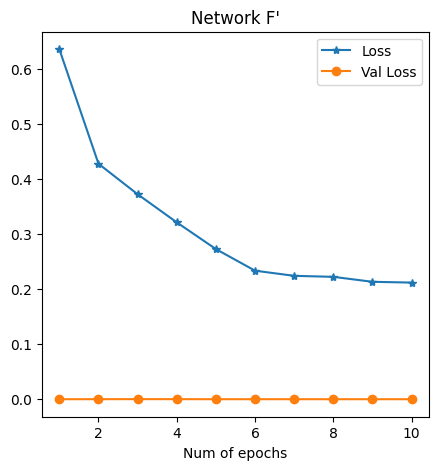

Epsilon: 0	Test Accuracy = 9114 / 10000 = 0.9114
Epsilon: 0.007	Test Accuracy = 9015 / 10000 = 0.9015
Epsilon: 0.01	Test Accuracy = 9007 / 10000 = 0.9007
Epsilon: 0.02	Test Accuracy = 8973 / 10000 = 0.8973
Epsilon: 0.03	Test Accuracy = 8935 / 10000 = 0.8935
Epsilon: 0.05	Test Accuracy = 8718 / 10000 = 0.8718
Epsilon: 0.1	Test Accuracy = 8046 / 10000 = 0.8046
Epsilon: 0.2	Test Accuracy = 4897 / 10000 = 0.4897
Epsilon: 0.3	Test Accuracy = 2008 / 10000 = 0.2008
Epsilon: 0	Test Accuracy = 9128 / 10000 = 0.9128
Epsilon: 0.007	Test Accuracy = 9018 / 10000 = 0.9018
Epsilon: 0.01	Test Accuracy = 9038 / 10000 = 0.9038
Epsilon: 0.02	Test Accuracy = 8954 / 10000 = 0.8954
Epsilon: 0.03	Test Accuracy = 8897 / 10000 = 0.8897
Epsilon: 0.05	Test Accuracy = 8735 / 10000 = 0.8735
Epsilon: 0.1	Test Accuracy = 8077 / 10000 = 0.8077
Epsilon: 0.2	Test Accuracy = 4935 / 10000 = 0.4935
Epsilon: 0.3	Test Accuracy = 1992 / 10000 = 0.1992
Epsilon: 0	Test Accuracy = 9102 / 10000 = 0.9102
Epsilon: 0.007	Test Accur

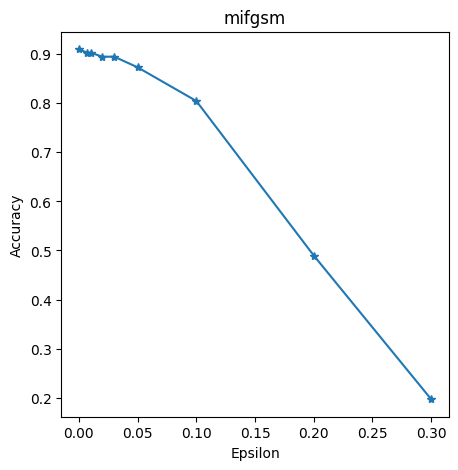

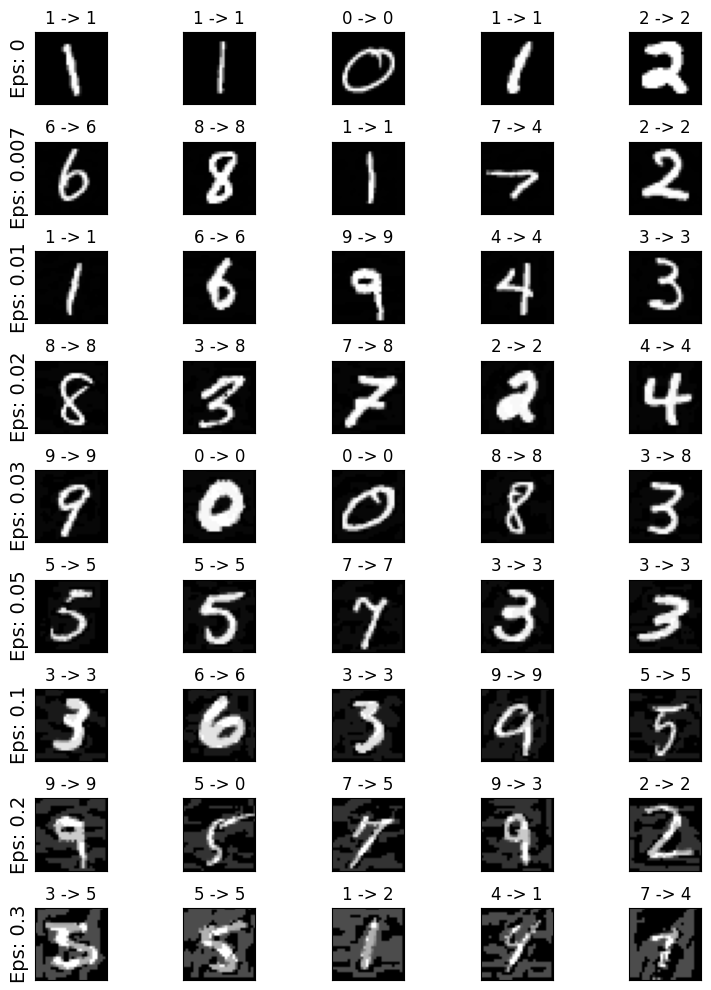

In [16]:
# получаем результаты оценки защищеных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)